# Gold Recovery

## Import Packages and Data

In [62]:
# Import packages
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [7]:
# Import data
def read_data(file_name):
    '''Takes a csv file name and returns a pandas data frame'''
    try:
        dataframe = pd.read_csv(f'/Users/kellyshreeve/Desktop/Data-Sets/{file_name}')
    except:
        dataframe = pd.read_csv(f'/datasets/{file_name}')
    
    return dataframe

# Apply read_data function to the three files
gold_full = read_data('gold_recovery_full.csv')
gold_full.name = 'Gold Recovery Full'

gold_train = read_data('gold_recovery_train.csv')
gold_train.name = 'Gold Recovery Train'

gold_test = read_data('gold_recovery_test.csv')
gold_test.name = 'Gold Recovery Test'

# Define list of dataframes
dataframes = [gold_full, gold_train, gold_test]

# For each dataframe, print shape, info, and head
for frame in dataframes:
    print(f'{frame.name}:')   
    print(f'Shape: {frame.shape}')
    print()
    print(frame.info())
    print(frame.head(10).to_string())
    

Gold Recovery Full:
Shape: (22716, 87)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol               

### Import data conclusion

Each csv has been read into python and saved as a pandas dataframe. The full dataframe has 22716 rows and 87 columns. The train dataframe has 16860 rows and 87 columns. The test dataframe has 5856 rows and 53 columns. Some variables present in the training dataframe are missing in the test set. There are missing values throughout all of the dataframes. Periods in variable names need to be changed to underscores to comply with snake case. The 'date' column in each data frame will need to be changed to date-time type. All other data types are correct. 

## Prepare Data

### Fix column names

In [8]:
# Change column names to snake case
dataframes = [gold_full, gold_train, gold_test]

for frame in dataframes:
    frame.columns = frame.columns.str.replace('.', '_')

/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_18341/1058002188.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  frame.columns = frame.columns.str.replace('.', '_')
/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_18341/1058002188.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  frame.columns = frame.columns.str.replace('.', '_')
/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_18341/1058002188.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  frame.columns = frame.columns.str.repl

### Check rougher output recovery is calculated correctly

Using the equation below, rougher concentrate recovery is re-calculated and compared to the rougher output recovery listed in the dataframe to ensure rougher concentrate recovery was calculated correctly.

![Screen Shot 2023-07-20 at 11.58.29 AM.png](<attachment:Screen Shot 2023-07-20 at 11.58.29 AM.png>)

![Screen Shot 2023-07-20 at 12.00.12 PM.png](<attachment:Screen Shot 2023-07-20 at 12.00.12 PM.png>)
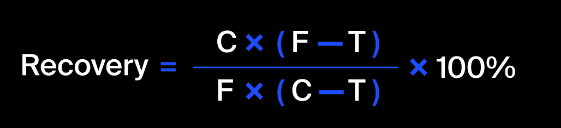
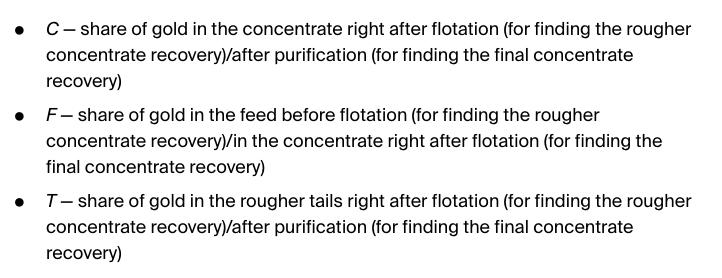

In [67]:
# Calculate rougher recovery

# Create a clean dataframe
gold_train_dropna = gold_train.dropna().copy()

# Define recovery function
def rougher_recovery(row):
    '''Takes a row and calculates rougher output recovery'''
    # Select columns for calculation
    C = row['rougher_output_concentrate_au']
    F = row['rougher_input_feed_au']
    T = row['rougher_output_tail_au']
    
    # Calculate recovery
    recovery = ((C * (F - T)) / (F * (C - T))) * 100
    return recovery

# Use rougher_recovery function to calculate a rougher_recovery_calculated feature
gold_train_dropna['rougher_recovery_calculated'] = gold_train_dropna.apply(rougher_recovery, axis=1)

print(gold_train_dropna.head().to_string())

                  date  final_output_concentrate_ag  final_output_concentrate_pb  final_output_concentrate_sol  final_output_concentrate_au  final_output_recovery  final_output_tail_ag  final_output_tail_pb  final_output_tail_sol  final_output_tail_au  primary_cleaner_input_sulfate  primary_cleaner_input_depressant  primary_cleaner_input_feed_size  primary_cleaner_input_xanthate  primary_cleaner_output_concentrate_ag  primary_cleaner_output_concentrate_pb  primary_cleaner_output_concentrate_sol  primary_cleaner_output_concentrate_au  primary_cleaner_output_tail_ag  primary_cleaner_output_tail_pb  primary_cleaner_output_tail_sol  primary_cleaner_output_tail_au  primary_cleaner_state_floatbank8_a_air  primary_cleaner_state_floatbank8_a_level  primary_cleaner_state_floatbank8_b_air  primary_cleaner_state_floatbank8_b_level  primary_cleaner_state_floatbank8_c_air  primary_cleaner_state_floatbank8_c_level  primary_cleaner_state_floatbank8_d_air  primary_cleaner_state_floatbank8_d_level  rou

In [68]:
# Calculate MAE of rougher_output_recovery and rougher_recovery_calculated
rougher_recovery_mae = mean_absolute_error(gold_train_dropna['rougher_output_recovery'], 
                                           gold_train_dropna['rougher_recovery_calculated'])

print(f'MAE: {rougher_recovery_mae}')

MAE: 9.460144184559453e-15


The Mean Absolute Error between the rougher recovery in the dataset and the rougher recovery calculated is almost 0. This represents no difference between the rougher recovery in the dataset and the calculated rougher recovery. The rougher output recovery in the dataset was calculated correctly.

### Fix data types

In [ ]:
# Change 'date' to date-time
for frame in dataframes:
    frame['date'] = pd.to_datetime(frame['date'], format='%Y/%m/%d %H:%M:%S')

### Check for duplicates

In [ ]:
for frame in dataframes:
    duplicates = frame.duplicated().sum()
    print(f'Number of duplicates {frame.name}: {duplicates}')

Number of duplicates Gold Recovery Full: 0
Number of duplicates Gold Recovery Train: 0
Number of duplicates Gold Recovery Test: 0


There are no duplicates in any of the data frames.

### Address missing values

In [ ]:
# Calculate percent of missing values for each column in each dataframe
for frame in dataframes:
    missing_count = frame.isna().sum()
    missing_percent = (missing_count/len(frame)) * 100
    missing_percent_round = missing_percent.round(2)
    
    print(f'{frame.name}')
    print()
    print(f'{missing_percent_round.to_string()}')
    print()

Gold Recovery Full

date                                                   0.00
final_output_concentrate_ag                            0.39
final_output_concentrate_pb                            0.38
final_output_concentrate_sol                           1.69
final_output_concentrate_au                            0.38
final_output_recovery                                  8.64
final_output_tail_ag                                   0.37
final_output_tail_pb                                   0.88
final_output_tail_sol                                  1.19
final_output_tail_au                                   0.36
primary_cleaner_input_sulfate                          7.08
primary_cleaner_input_depressant                       6.81
primary_cleaner_input_feed_size                        0.00
primary_cleaner_input_xanthate                         5.07
primary_cleaner_output_concentrate_ag                  0.43
primary_cleaner_output_concentrate_pb                  1.97
primary_cleaner_outp